In [2]:
# Analyze data
import pandas as pd
import numpy as np
from collections import Counter
import statistics

# Remove warnings
import warnings
warnings.simplefilter("ignore")

# Plot graphs
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# from pytorch_tabnet.tab_model import TabNetClassifier
from catboost import CatBoostClassifier

# Data preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, KFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler, MinMaxScaler, Normalizer
from sklearn.preprocessing import LabelEncoder

# Scoring
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [4]:
data_dir = '../data/'

# GH_data - e-coli
gh_data = pd.read_csv(data_dir + 'e-coli-data.csv')

# ITMO_data - fermented milk bacteria
itmo_data = pd.read_csv(data_dir + 'molochka.csv')

itmo_data.sample(5)

,Compound,0.02 V,0.1 V,0.5 V,1.0 V,5.0 V
7159,10^6,0.000002,-0.000001,-0.000017,-0.000081,-0.010980
5512,10^6,0.000001,-0.000001,-0.000008,-0.000090,-0.001060
12426,control,-0.000001,-0.000001,-0.000001,0.000004,-0.000129
7678,10^7,0.000004,0.000002,0.000003,0.000024,0.000941
5733,10^6,0.000004,0.000002,0.000013,0.000082,0.002260


___

# Encode **Compound** values

In [5]:
le_g = LabelEncoder()
le_i = LabelEncoder()

gh_data['Compound'] = le_g.fit_transform(gh_data['Compound'])
itmo_data['Compound'] = le_i.fit_transform(itmo_data['Compound'])

gh_data.sample(5)

,Compound,0.02 V,0.1 V,0.5 V,1 V,5 V
27116,3,-9.577370e-07,1.836980e-06,2.631240e-05,0.000146,0.011130
18174,0,-9.115660e-07,-3.125940e-06,-1.606520e-05,-0.000065,-0.004290
9032,6,1.988130e-06,3.276030e-07,-6.667160e-06,-0.000033,-0.000728
30767,2,-8.594770e-07,-6.382940e-07,-8.626640e-07,-0.000002,0.000288
35029,1,4.178220e-06,4.244570e-06,1.575700e-05,0.000071,0.009700


In [6]:
itmo_data.sample(5)

,Compound,0.02 V,0.1 V,0.5 V,1.0 V,5.0 V
1665,0,-1.842190e-06,-1.426860e-06,-1.464000e-06,9.361580e-07,-0.000401
3126,1,-5.109850e-07,-1.233230e-06,-6.842870e-06,-1.567390e-05,-0.001350
12411,5,-1.458640e-06,-1.471350e-06,-2.510950e-06,-3.820320e-06,-0.001160
5650,2,4.174920e-06,3.150120e-07,-1.112120e-08,2.499590e-06,-0.000090
7847,3,3.152760e-06,1.521220e-06,-9.742610e-07,-2.324890e-06,0.000246


In [7]:
print(le_i.classes_)
print(le_g.classes_)

['10^4' '10^5' '10^6' '10^7' '10^8' 'control']
['0 (CFU/ml)' '10² (CFU/ml)' '10³ (CFU/ml)' '10⁴ (CFU/ml)' '10⁵ (CFU/ml)'
 '10⁶ (CFU/ml)' '10⁷ (CFU/ml)' '10⁸ (CFU/ml)' '10⁹ (CFU/ml)']


___

# **Compound** distribution before `under_sampling`

## Why not `over_sampling`?

- The difference between majority and minority is massive.

## Why even bother?

- Model might find a pattern at which prob. of mistake is lower at majority.  

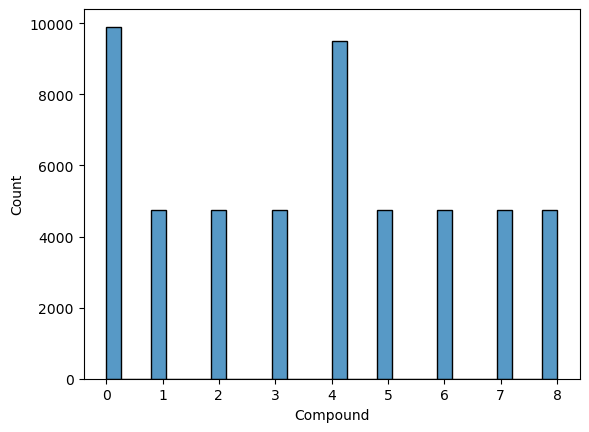

In [8]:
sns.histplot(gh_data['Compound']);

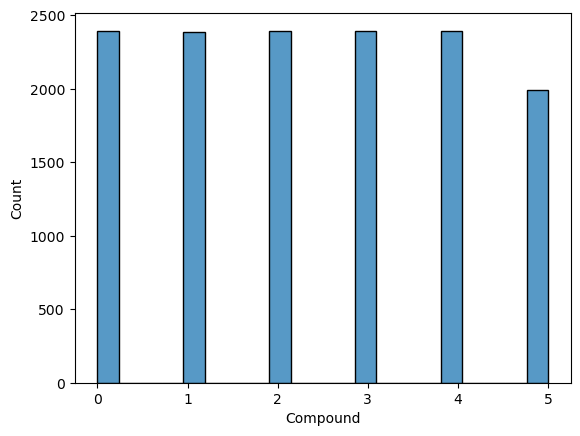

In [9]:
sns.histplot(itmo_data['Compound']);

___

# After `under_sampling`

In [45]:
# For e-coli

Xg = gh_data.drop(columns=['Compound'])
yg = gh_data['Compound']

Xg_train, Xg_test, yg_train, yg_test = train_test_split(Xg, yg, test_size=0.2, random_state=1)

under_sampler = RandomUnderSampler(random_state=1)
Xg_train, yg_train = under_sampler.fit_resample(Xg_train, yg_train)
print("Class distr. before UnderSampling", Counter(yg_train))

Class distr. before UnderSampling Counter({'10^4': 3780, '10^5': 3780, '10^6': 3780, '10^7': 3780, '10^8': 3780, 'control': 3780})


In [11]:
# Для milk bacteria

Xi = itmo_data.drop(columns=['Compound'])
yi = itmo_data['Compound']

Xi_train, Xi_test, yi_train, yi_test = train_test_split(Xi, yi, test_size=0.2, random_state=1)

under_sampler = RandomUnderSampler(random_state=1)
Xi_train, yi_train = under_sampler.fit_resample(Xi_train, yi_train)
print("Class distr. before UnderSampling:", Counter(yi_train))

Class distr. before UnderSampling: Counter({0: 1588, 1: 1588, 2: 1588, 3: 1588, 4: 1588, 5: 1588})


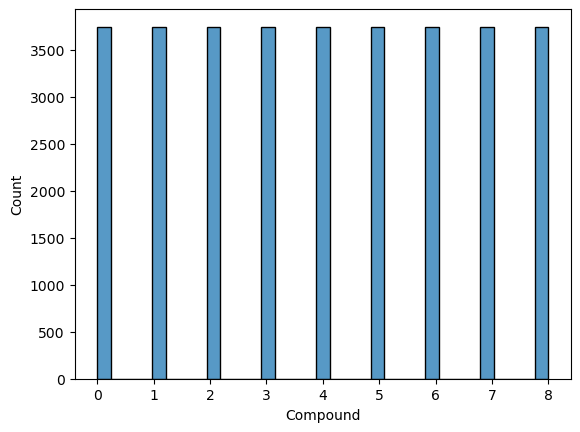

In [12]:
sns.histplot(yg_train);

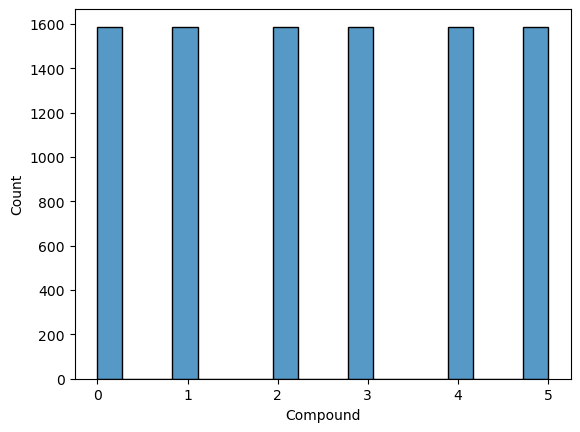

In [13]:
sns.histplot(yi_train);

In [14]:
# MinMaxScaled Data

mms_g = MinMaxScaler()
mms_i = MinMaxScaler()

mms_g.fit(Xg_train)
Xg_mms_train = mms_g.transform(Xg_train)
Xg_mms_test = mms_g.transform(Xg_test)

mms_i.fit(Xi_train)
Xi_mms_train = mms_i.transform(Xi_train)
Xi_mms_test = mms_i.transform(Xi_test)

In [15]:
# RobustScaled Data

rs_g = RobustScaler()
rs_i = RobustScaler()

rs_g.fit(Xg_train)
Xg_rs_train = rs_g.transform(Xg_train)
Xg_rs_test = rs_g.transform(Xg_test)

rs_i.fit(Xi_train)
Xi_rs_train = rs_i.transform(Xi_train)
Xi_rs_test = rs_i.transform(Xi_test)

In [16]:
# Normalized Data

ner_g = Normalizer()
ner_i = Normalizer()

ner_g.fit(Xg_train)
Xg_ner_train = ner_g.transform(Xg_train)
Xg_ner_test = ner_g.transform(Xg_test)

ner_i.fit(Xi_train)
Xi_ner_train = ner_i.transform(Xi_train)
Xi_ner_test = ner_i.transform(Xi_test)

In [17]:
scaler = MinMaxScaler()

Xg_scaled = scaler.fit_transform(Xg)

___

## Models to consider:

- **Random Forest Classifiers (RF) / Extra Trees Classifier (ET)** : _"Bacterial species identification from MALDI-TOF mass spectra 
through data analysis and machine learning"_

- **Support Vector Machines (SVM)** : _"Bacterial species identification from MALDI-TOF mass spectra 
through data analysis and machine learning"_

- **Artificial Neural Networks (ANN)** : _"Towards large-scale FAME-based bacterial species identification using 
machine learning techniques"_

- **Catboost (CBC)**: _Gradient boosting_

- **Logistic Regression (LR)** : _Check for linear correlation_


## Metrics:

- Accuracy
- Recall
- Precision
- F1-score

## Preprocessing methods:

- RobustScaler
- Normalizer
- MinMaxScaler

___

# Train models

In [18]:
def train_model(models, X_train, y_train, X_test, y_test):
    acc  = []
    mod  = []
    prec = []
    rec  = []
    f1   = []

    for i in range(len(models)):
        mod.append(str(models[i]))

        models[i].fit(X_train, y_train)
        y_pred = models[i].predict(X_test)

        acc.append(accuracy_score(y_test, y_pred))
        prec.append(precision_score(y_test, y_pred, average='macro'))
        rec.append(recall_score(y_test, y_pred, average='macro'))
        f1.append(f1_score(y_test, y_pred, average='macro'))

    data = {'Model'     : mod,
            'Accuracy'  : acc,
            'Precision' : prec,
            'Recall'    : rec,
            'F1-score'  : f1}
    
    return pd.DataFrame(data)

In [21]:
model_list = [RandomForestClassifier(), ExtraTreesClassifier(), SVC(), LogisticRegression()]

___

# **E-coli**

## No prep.

In [22]:
train_model(model_list, Xg_train, yg_train, Xg_test, yg_test)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForestClassifier(),0.980824,0.977860,0.980219,0.978957
1,ExtraTreesClassifier(),0.995918,0.995274,0.996445,0.995849
2,SVC(),0.161857,0.353136,0.167530,0.158146
3,LogisticRegression(),0.090374,0.134312,0.110484,0.043588


## MinMax

In [23]:
train_model(model_list, Xg_mms_train, yg_train, Xg_mms_test, yg_test)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForestClassifier(),0.988324,0.987108,0.989051,0.988048
1,ExtraTreesClassifier(),0.996108,0.995697,0.996591,0.996138
2,SVC(),0.534460,0.541019,0.565166,0.518676
3,LogisticRegression(),0.364534,0.370977,0.364379,0.365353


## Robust

In [24]:
train_model(model_list, Xg_rs_train, yg_train, Xg_rs_test, yg_test)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForestClassifier(),0.989747,0.988683,0.990396,0.989514
1,ExtraTreesClassifier(),0.995918,0.995597,0.996316,0.995954
2,SVC(),0.630150,0.650223,0.659073,0.629775
3,LogisticRegression(),0.378394,0.386721,0.375492,0.379391


## Normalizer

In [25]:
train_model(model_list, Xg_ner_train, yg_train, Xg_ner_test, yg_test)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForestClassifier(),0.923866,0.915541,0.926138,0.919752
1,ExtraTreesClassifier(),0.936681,0.929509,0.940019,0.933827
2,SVC(),0.222138,0.330578,0.181243,0.180248
3,LogisticRegression(),0.288305,0.314476,0.276117,0.277605


# **Milk bacteria**

## No prep.

In [26]:
train_model(model_list, Xi_train, yi_train, Xi_test, yi_test)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForestClassifier(),0.985299,0.985447,0.984472,0.984886
1,ExtraTreesClassifier(),0.995697,0.995741,0.995552,0.995642
2,SVC(),0.236644,0.238090,0.229799,0.195587
3,LogisticRegression(),0.164934,0.055098,0.158731,0.081099


## MinMax

In [27]:
train_model(model_list, Xi_mms_train, yi_train, Xi_mms_test, yi_test)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForestClassifier(),0.991753,0.991768,0.991454,0.991601
1,ExtraTreesClassifier(),0.995697,0.995736,0.995548,0.995639
2,SVC(),0.763715,0.783234,0.749848,0.729153
3,LogisticRegression(),0.636787,0.610588,0.624517,0.602100


## Robust

In [28]:
train_model(model_list, Xi_rs_train, yi_train, Xi_rs_test, yi_test)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForestClassifier(),0.991753,0.991845,0.991462,0.991638
1,ExtraTreesClassifier(),0.994980,0.994974,0.994795,0.994878
2,SVC(),0.808534,0.816640,0.798018,0.790990
3,LogisticRegression(),0.645751,0.624557,0.635074,0.620930


## Normalizer

In [29]:
train_model(model_list, Xi_ner_train, yi_train, Xi_ner_test, yi_test)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForestClassifier(),0.937253,0.936956,0.935428,0.935891
1,ExtraTreesClassifier(),0.952671,0.952166,0.951259,0.951590
2,SVC(),0.230549,0.308237,0.235217,0.190013
3,LogisticRegression(),0.274650,0.341542,0.272795,0.239093


___

# Visualize results using histogram

In [30]:
recall_scores = []

for model in model_list:
    model.fit(Xg_rs_train, yg_train)
    recall_scores.append(f1_score(yg_test, model.predict(Xg_rs_test), average='macro'))

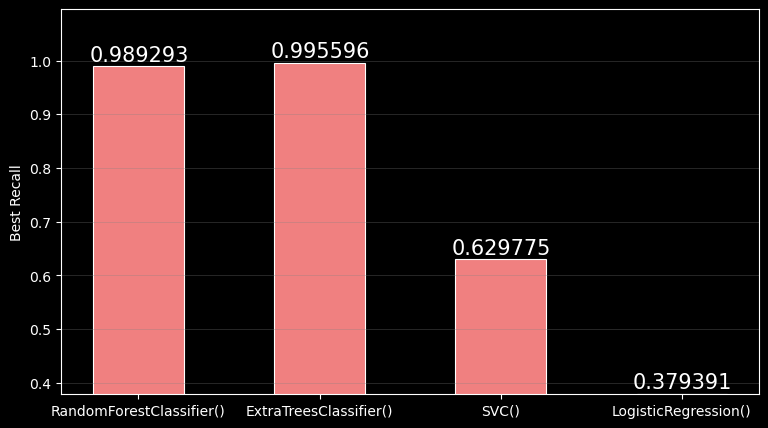

In [36]:
plt.style.use(['dark_background'])
plt.figure(figsize=(9, 5))

plt.bar(range(len(recall_scores)), recall_scores, color='lightcoral', width=0.5, edgecolor='white', linewidth=0.8)

for i, v in enumerate(recall_scores):
    plt.text(i-0.27, v+0.01, str(round(v, 6)), fontsize=15)

plt.ylabel('Best Recall')
plt.ylim(min(recall_scores)-0.001, max(recall_scores)+0.1)
plt.xticks([i for i in range(len(recall_scores))], model_list)
plt.grid(color='grey', linewidth=0.7, axis='y', alpha=0.3)

plt.show()

___

# Cross Validation Scores

In [37]:
model = ExtraTreesClassifier()

values = cross_val_score(model, Xg_scaled, yg, cv=KFold(shuffle=True))

print(values)
print(statistics.mean(values))

[0.99743687 0.99819632 0.99734194 0.99895566 0.99705687]
0.9977975320397198


In [38]:
model = RandomForestClassifier()

values = cross_val_score(model, Xg_scaled, yg, cv=KFold(shuffle=True))

print(values)
print(statistics.mean(values))

[0.9928802  0.99098158 0.98984242 0.99335422 0.98955663]
0.9913230095092388


___

# Optimize "Catboost Classifier" 

In [17]:
clf =  CatBoostClassifier(task_type='GPU', bootstrap_type='Poisson', eval_metric='Accuracy', loss_function='MultiClass')

grid = {
        'depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'learning_rate': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
        'l2_leaf_reg': [1, 20, 50, 100],
        'iterations': [100, 300, 600, 1000, 5000],
        'early_stopping_rounds': [50],
        'verbose': [250]
    }

In [ ]:
clf.grid_search(grid, Xg_mms_train, yg_train, plot=False, cv=3, shuffle=True, stratified=True, refit=True, verbose=100)

# Best params

```python
task_type='GPU',
bootstrap_type='Poisson',
eval_metric='Accuracy',
loss_function='MultiClass',
depth=8,
od_wait=50,
l2_leaf_reg=1,
iterations=5000,
learning_rate=0.1,
verbose=250
```

In [47]:
clf =  CatBoostClassifier(task_type='GPU',
                          bootstrap_type='Poisson',
                          eval_metric='Accuracy',
                          loss_function='MultiClass',
                          depth=8,
                          od_wait=50,
                          l2_leaf_reg=1,
                          iterations=5000,
                          learning_rate=0.1,
                          verbose=500)

In [33]:
clf.fit(Xg_mms_train, yg_train)

0:	learn: 0.4794057	total: 12.4ms	remaining: 1m 1s
250:	learn: 0.9511016	total: 3.01s	remaining: 56.9s
500:	learn: 0.9859740	total: 6.03s	remaining: 54.1s
750:	learn: 0.9950182	total: 8.97s	remaining: 50.8s
1000:	learn: 0.9982208	total: 12s	remaining: 48.1s
1250:	learn: 0.9991994	total: 15.1s	remaining: 45.3s
1500:	learn: 0.9994662	total: 18.1s	remaining: 42.3s
1750:	learn: 0.9997924	total: 21.2s	remaining: 39.3s
2000:	learn: 0.9999110	total: 24.2s	remaining: 36.3s
2250:	learn: 0.9999110	total: 27.3s	remaining: 33.3s
2500:	learn: 0.9999110	total: 30.3s	remaining: 30.3s
2750:	learn: 0.9999110	total: 33.2s	remaining: 27.2s
3000:	learn: 0.9999110	total: 36.2s	remaining: 24.1s
3250:	learn: 0.9999110	total: 39.4s	remaining: 21.2s
3500:	learn: 0.9999110	total: 42.4s	remaining: 18.1s
3750:	learn: 0.9999110	total: 45.3s	remaining: 15.1s
4000:	learn: 0.9999110	total: 48.2s	remaining: 12s
4250:	learn: 0.9999110	total: 51.2s	remaining: 9.03s
4500:	learn: 0.9999110	total: 54.2s	remaining: 6.01s
47

In [27]:
f1_score(yg_test, clf.predict(Xg_mms_test), average='macro')

0.9925325729206926

In [ ]:
recall_score(yg_test, clf.predict(Xg_mms_test), average='macro')

In [29]:
accuracy_score(yg_test, clf.predict(Xg_mms_test))

0.992500474653503

In [ ]:
cross_val_score(clf, Xg_mms_test, yg_test, cv=StratifiedKFold(shuffle=True))

In [11]:
clf =  CatBoostClassifier(task_type='GPU',
                          bootstrap_type='Poisson',
                          eval_metric='Accuracy',
                          loss_function='MultiClass',
                          depth=8,
                          od_wait=50,
                          l2_leaf_reg=1,
                          iterations=5000,
                          learning_rate=0.1,
                          verbose=250)

cross_val_score(clf, Xg, yg, cv=StratifiedKFold(shuffle=True))

0:	learn: 0.4978877	total: 23.8s	remaining: 1d 8h 59m 39s
250:	learn: 0.9482128	total: 26.8s	remaining: 8m 27s
500:	learn: 0.9845730	total: 29.8s	remaining: 4m 27s
750:	learn: 0.9949447	total: 32.8s	remaining: 3m 5s
1000:	learn: 0.9977928	total: 35.9s	remaining: 2m 23s
1250:	learn: 0.9990981	total: 39s	remaining: 1m 56s
1500:	learn: 0.9996440	total: 42s	remaining: 1m 37s
1750:	learn: 0.9998813	total: 44.9s	remaining: 1m 23s
2000:	learn: 0.9999288	total: 47.9s	remaining: 1m 11s
2250:	learn: 0.9999525	total: 50.8s	remaining: 1m 2s
2500:	learn: 0.9999763	total: 53.8s	remaining: 53.7s
2750:	learn: 0.9999763	total: 56.9s	remaining: 46.5s
3000:	learn: 0.9999763	total: 59.9s	remaining: 39.9s
3250:	learn: 0.9999763	total: 1m 2s	remaining: 33.9s
3500:	learn: 0.9999763	total: 1m 5s	remaining: 28.2s
3750:	learn: 0.9999763	total: 1m 8s	remaining: 22.9s
4000:	learn: 0.9999763	total: 1m 11s	remaining: 17.9s
4250:	learn: 0.9999763	total: 1m 14s	remaining: 13.2s
4500:	learn: 0.9999763	total: 1m 17s	re

array([0.99525346, 0.9950636 , 0.9953484 , 0.9925947 , 0.99544289])

___

# TabNet

In [35]:
clf= TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       scheduler_params={"step_size":10, 
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                      )

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [36]:
clf.fit(
    Xg_mms_train, yg_train.values,
    eval_set=[(Xg_mms_train, yg_train.values), (Xg_mms_test, yg_test.values)],
    eval_name=['train', 'test'],
    eval_metric=['balanced_accuracy'],
    max_epochs=450, patience=150,
    batch_size=512, virtual_batch_size=512,
    num_workers=0,
    weights=1,
    drop_last=False
)       

epoch 0  | loss: 1.55536 | train_balanced_accuracy: 0.11025 | test_balanced_accuracy: 0.10939 |  0:00:02s
epoch 1  | loss: 1.02894 | train_balanced_accuracy: 0.2286  | test_balanced_accuracy: 0.23131 |  0:00:05s
epoch 2  | loss: 0.90316 | train_balanced_accuracy: 0.22451 | test_balanced_accuracy: 0.2218  |  0:00:07s
epoch 3  | loss: 0.87086 | train_balanced_accuracy: 0.25967 | test_balanced_accuracy: 0.25759 |  0:00:09s
epoch 4  | loss: 0.79726 | train_balanced_accuracy: 0.30522 | test_balanced_accuracy: 0.3034  |  0:00:12s
epoch 5  | loss: 0.78358 | train_balanced_accuracy: 0.38876 | test_balanced_accuracy: 0.3871  |  0:00:14s
epoch 6  | loss: 0.73225 | train_balanced_accuracy: 0.44486 | test_balanced_accuracy: 0.45026 |  0:00:16s
epoch 7  | loss: 0.73314 | train_balanced_accuracy: 0.64019 | test_balanced_accuracy: 0.64018 |  0:00:19s
epoch 8  | loss: 0.69657 | train_balanced_accuracy: 0.58468 | test_balanced_accuracy: 0.57998 |  0:00:21s
epoch 9  | loss: 0.70116 | train_balanced_accu

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [25]:
clf.fit(
    Xg_ss_train, yg_train.values,
    eval_set=[(Xg_ss_train, yg_train.values), (Xg_ss_test, yg_test.values)],
    eval_name=['train', 'test'],
    eval_metric=['balanced_accuracy'],
    max_epochs=550, patience=150,
    batch_size=512, virtual_batch_size=512,
    num_workers=0,
    weights=1,
    drop_last=False
)       

epoch 0  | loss: 1.60145 | train_balanced_accuracy: 0.2965  | test_balanced_accuracy: 0.2985  |  0:00:02s
epoch 1  | loss: 1.08759 | train_balanced_accuracy: 0.4392  | test_balanced_accuracy: 0.43793 |  0:00:05s
epoch 2  | loss: 0.96516 | train_balanced_accuracy: 0.534   | test_balanced_accuracy: 0.52612 |  0:00:07s
epoch 3  | loss: 0.87986 | train_balanced_accuracy: 0.52383 | test_balanced_accuracy: 0.52983 |  0:00:10s
epoch 4  | loss: 0.81669 | train_balanced_accuracy: 0.58545 | test_balanced_accuracy: 0.58293 |  0:00:12s
epoch 5  | loss: 0.80312 | train_balanced_accuracy: 0.67325 | test_balanced_accuracy: 0.66341 |  0:00:14s
epoch 6  | loss: 0.74086 | train_balanced_accuracy: 0.68642 | test_balanced_accuracy: 0.6818  |  0:00:17s
epoch 7  | loss: 0.73474 | train_balanced_accuracy: 0.65578 | test_balanced_accuracy: 0.6552  |  0:00:19s
epoch 8  | loss: 0.73653 | train_balanced_accuracy: 0.68926 | test_balanced_accuracy: 0.6875  |  0:00:22s
epoch 9  | loss: 0.71389 | train_balanced_accu

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


___

# **Hypothesis**: our model can figure out compound of each type of bacteria without any information about type.

In [40]:
gh_data = pd.read_csv(data_dir + 'e-coli-data.csv')
itmo_data = pd.read_csv(data_dir + 'molochka.csv')

values_to_remove = ['10³ (CFU/ml)', '10² (CFU/ml)', '10⁹ (CFU/ml)']

gh_data.drop(gh_data[gh_data['Compound'].isin(values_to_remove)].index, inplace=True)
name_mapping = dict([('10⁸ (CFU/ml)', '10^8'), ('10⁷ (CFU/ml)', '10^7'), ('10⁶ (CFU/ml)', '10^6'), ('10⁵ (CFU/ml)', '10^5'), ('0 (CFU/ml)', 'control'), ('10⁴ (CFU/ml)', '10^4')])
itmo_data.rename(columns={'1.0 V':'1 V', '5.0 V': '5 V'}, inplace=True)
gh_data.Compound = gh_data.Compound.map(name_mapping)

data = pd.concat([gh_data, itmo_data], ignore_index=True)

data.sample(5)

,Compound,0.02 V,0.1 V,0.5 V,1 V,5 V
3296,10^8,6.434180e-06,0.000012,0.000026,0.000080,0.001710
13813,10^5,3.735820e-06,0.000001,-0.000008,-0.000045,-0.002820
42720,10^5,-2.151770e-07,-0.000001,-0.000007,-0.000085,-0.000818
1290,10^8,5.454800e-07,-0.000005,0.000006,0.000031,0.000777
7502,10^6,2.114550e-05,0.000011,-0.000021,-0.000055,-0.007140


<Axes: xlabel='Compound', ylabel='Count'>

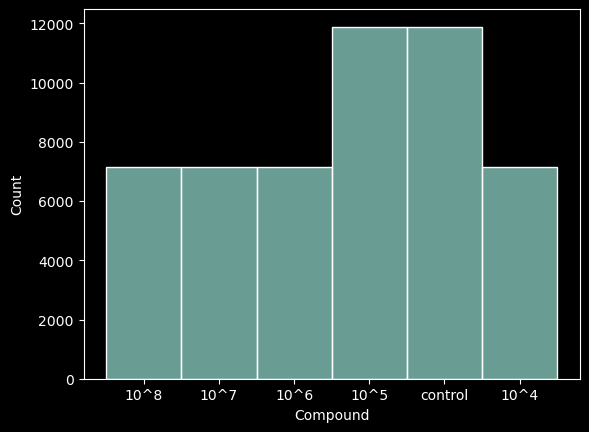

In [41]:
sns.histplot(data.Compound)

In [42]:
X = data.drop(columns=['Compound'])
y = data['Compound']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

under_sampler = RandomUnderSampler(random_state=1)
X_train, y_train = under_sampler.fit_resample(X_train, y_train)
print("Distr. before UnderSampling", Counter(y_train))

Distr. before UnderSampling Counter({'10^4': 5672, '10^5': 5672, '10^6': 5672, '10^7': 5672, '10^8': 5672, 'control': 5672})


In [43]:
# Scalers
mms = MinMaxScaler()
rs = RobustScaler()
ner = Normalizer()

X_train_mms = mms.fit_transform(X_train) 
X_test_mms = mms.fit_transform(X_test)

X_train_rs = rs.fit_transform(X_train) 
X_test_rs = rs.fit_transform(X_test)

X_train_ner = ner.fit_transform(X_train) 
X_test_ner = ner.fit_transform(X_test)


In [44]:
train_model(model_list, X_train_mms, y_train, X_test_mms, y_test)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForestClassifier(),0.375764,0.394488,0.363199,0.326817
1,ExtraTreesClassifier(),0.411287,0.431585,0.400846,0.360417
2,SVC(),0.348930,0.573285,0.369168,0.372791
3,LogisticRegression(),0.338522,0.487919,0.320799,0.230016


> As it turned out: our hypothesis was wrong

___

# Result

Best model: "**Catboost Classifier**" with mean vals (across all tests on my machine):

$ Accuracy = 0.99544289, $ 
$ F1_{score} = 0.99253257 $
$ Recall = 0.9879812381$ 

### Why **Catboost Classifier** if **Extra Trees Classifier** _"has better accuracy"_?

Catboost Classifier is less prone to overfitting than Extra Trees Classifier. Moreover,
the overfitting could be accidental because data is not that extensive.

Furthermore, Catboost Classifier has more hyperparameters to tune which makes CBC more
optimal.

___

# **Histogram**

It is worth mentioning that difference is not that noticable - from 0.002 to 0.0002:

<img src="../images/Screenshot_1.png">